In [1]:
import sys, os, itertools, sklearn
sys.path.append('/home/roquero/CausalAggregation/Code')
import pandas as pd
import numpy as np
import _pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn.linear_model import LassoCV, Lasso
from sklearn import datasets
from sklearn.metrics import auc
from scipy.interpolate import UnivariateSpline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%reload_ext autoreload
%autoreload 2
np.set_printoptions(suppress=True)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)}, linewidth=100000)
from backfitting import Backfitting
from base_environment import BaseEnvironment
from collection_environment import CollectionEnvironment
from regression_method import PolynomialRegression, RandomForestRegression
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures


/home/roquero/miniconda3/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
ik_h, se_h = [], (lambda input_samples:input_samples)
ik_x1, se_x1 = ['h'], (lambda input_samples: 2*input_samples[0] + input_samples[1])
ik_x2, se_x2 = ['h', 'x1'], (lambda input_samples: input_samples[0] + input_samples[1] + input_samples[2])
ik_x3, se_x3 = ['x1', 'x2'], (lambda input_samples: -input_samples[0] * 2*input_samples[1] + input_samples[2])
#ik_x4, se_x4 = ['x1', 'x3'], (lambda input_samples: input_samples[0] + input_samples[1] + input_samples[2])
ik_x4, se_x4 = ['x1', 'x3'], (lambda input_samples: np.log(1+np.abs(input_samples[0])) + input_samples[1] + input_samples[2])
#ik_y, se_y = ['h','x1','x2','x3','x4'], (lambda input_samples:
#                                         input_samples[0] 
#                                         + input_samples[1]**2
#                                         + 0.5*input_samples[1]*input_samples[2]*input_samples[3]
#                                         - 0.5*input_samples[3]*input_samples[4]
#                                         - input_samples[2]*input_samples[4] + input_samples[5])
ik_y, se_y = ['h','x1','x2','x3','x4'], (lambda input_samples:
                                         (input_samples[0]>0).astype(float)
                                         + (input_samples[1]<-1).astype(float)
                                         + 0.5*(input_samples[1]>0).astype(float)*(input_samples[2]>0.5).astype(float)*(input_samples[3]<0.5).astype(float)
                                         - 0.5*(input_samples[3]<-0.5).astype(float)*(input_samples[4]<0).astype(float)
                                         - (input_samples[2]<0).astype(float)*(input_samples[4]>-0.5).astype(float) + input_samples[5])
ik_x5, se_x5 = ['x2', 'x4', 'y'], (lambda input_samples: 2*input_samples[0] + input_samples[1] - input_samples[2] + input_samples[3])

In [3]:
fh = {'input_keys':ik_h, 'structural_eq': se_h}
f1 = {'input_keys':ik_x1, 'structural_eq': se_x1}
f2 = {'input_keys':ik_x2, 'structural_eq': se_x2}
f3 = {'input_keys':ik_x3, 'structural_eq': se_x3}
f4 = {'input_keys':ik_x4, 'structural_eq': se_x4}
f5 = {'input_keys':ik_x5, 'structural_eq': se_x5}
fy = {'input_keys':ik_y, 'structural_eq': se_y}

sh = lambda n_samples: np.random.normal(size=n_samples)/200
s1 = lambda n_samples: np.random.normal(size=n_samples)
s2 = lambda n_samples: np.random.normal(size=n_samples)
s3 = lambda n_samples: np.random.normal(size=n_samples)
s4 = lambda n_samples: np.random.normal(size=n_samples)
s5 = lambda n_samples: np.random.normal(size=n_samples)
sy = lambda n_samples: np.random.normal(size=n_samples)/500

topo_order = ['h','x1','x2','x3','x4','y','x5']
y_key = 'y'
x_key = ['x1','x2','x3','x4','x5']

structural_equation_dict = {'x1':f1, 'x2':f2, 'x3':f3, 'y':fy, 'x4':f4, 'x5':f5, 'h':fh}
disturbance_sampler_dict = {'x1':s1, 'x2':s2, 'x3':s3, 'y':sy, 'x4':s4, 'x5':s5, 'h':sh}

base = BaseEnvironment(structural_equation_dict, disturbance_sampler_dict, topo_order, y_key, x_key)
coll_env = CollectionEnvironment(base)

In [4]:
coll_env.add_env('e1', {'x1':{'type':'independent'},'x2':{'type':'independent'}, 'x3':{'type':'independent'}}, 10000)
coll_env.add_env('e2', {'x2':{'type':'independent'},'x4':{'type':'independent'}}, 10000)
coll_env.add_env('e3', {'x4':{'type':'independent'},'x3':{'type':'independent'}}, 10000)
coll_env.add_env('e4', {'x1':{'type':'independent'},'x5':{'type':'independent'}}, 10000)


In [5]:
coll_env.env['e1'].data['X'].mean(axis=1)

array([-0.001, 0.001, 0.008, 0.550, 0.314])

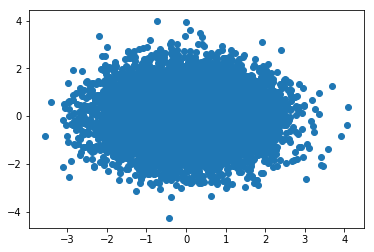

In [6]:
plt.scatter(coll_env.env['e1'].data['X'][0,:],coll_env.env['e1'].data['X'][1,:])

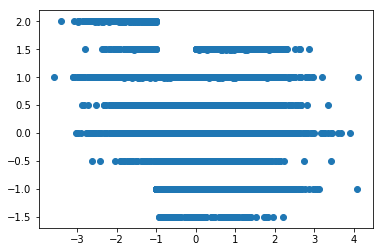

In [7]:
plt.scatter(coll_env.env['e1'].data['X'][0,:],coll_env.env['e1'].data['Y'])

In [8]:
params_method = {'regression_method':'HuberRegressor',
                 'power_features': {
                     'e1':10,
                     'e2':10,
                     'e3':10,
                     'e4':10,
                     'e5':10,
                                     },
                 'selected_features':{
                     'e1':['1','x1^0', 'x2^0','x2^2',  'x3^0', 'x1^2', 'x1^0x2^0', 'x1^0x3^0',  'x2^0x3^0', 'x3^2', 'x1^3',
                           'x1^2x2^0', 'x1^2x3^0', 'x1^0x2^2', 'x1^0x2^0x3^0', 'x1^0x3^2', 'x2^3', 'x2^2x3^0', 'x2^0x3^2', 'x3^3'],
                     'e2':['x2^0x4^0'],
                     'e3':['x3^0x4^0'],
                     'e4':['x1^0x5^0'],
                 },
                 'n_estimators':60
                }

backfit = Backfitting(RandomForestRegression, 
                      'backfitting',
                      max_n_iter=20,
                      gap_convergence=1e-5,
                      warm_start=False, 
                      params_method=params_method)
                      
res = backfit.fit(coll_env)

100%|██████████| 20/20 [10:16<00:00, 30.81s/it]


In [9]:
backfit.output_model_variation

{'e1': [0.11691781938223944,
  0.06450487304122733,
  0.10023429323417715,
  0.01886220257415403,
  0.16142282593010981,
  0.06512175595628442,
  0.20378268472491523,
  0.30839985169997997,
  0.2724914706673165,
  0.3099841750032227,
  0.8529922808624557,
  0.04195625021747568,
  0.6459982134148272,
  1.071932713322722,
  0.5904417553814977,
  0.7649368269139707,
  1.161540051274229,
  0.0874532583858916,
  1.7267923323659002],
 'e2': [0.08517858194753387,
  0.09063597593683541,
  0.023815687978354348,
  0.11417294257181008,
  0.07767719620297119,
  0.22171767407749787,
  0.13808065668347733,
  0.25569941756328324,
  0.24393880256527017,
  0.3771771988608282,
  0.21509727588667518,
  0.5263302046807008,
  0.1677873316460348,
  0.6085400519364786,
  1.225227491787543,
  0.7984478173066439,
  0.6017674630283232,
  1.089105487762158,
  0.2763900208570172],
 'e3': [0.14448081461918827,
  0.013624760087438773,
  0.08447373729010559,
  0.08586208542832845,
  0.08322199886820413,
  0.06412307

In [10]:
samples = np.random.normal(size=(6,10))
samples

array([[0.098, -0.856, -0.797, 0.253, 0.798, -0.455, 0.379, 0.332, -1.042, 1.169],
       [2.438, -0.403, 0.748, -1.159, 0.355, 0.545, 0.189, -0.936, -0.721, -0.644],
       [0.026, 0.136, -0.378, -0.409, 0.238, -0.238, 0.159, -0.181, 0.945, -0.527],
       [-1.972, -0.629, -0.330, 0.857, 1.893, 1.235, -0.933, -0.272, 0.454, -1.463],
       [0.303, 0.678, -1.307, 1.403, 1.057, -0.342, -1.474, -0.015, 2.391, 0.065],
       [-1.486, -1.196, 2.182, 0.152, -0.995, -0.704, -0.313, 1.157, 0.854, 1.863]])

In [11]:
backfit.true_function_y(backfit.x_train_full[:,:10])
backfit.output_function_merged(backfit.x_train_full[:,:10])

array([0.000, 0.000, 0.000, 1.000, 0.500, 0.000, 0.000, -0.500, 0.000, -1.000])

array([0.475, 0.773, 0.299, 1.006, 2.428, 0.392, 0.402, -0.620, -0.096, -0.765])

In [12]:
backfit.true_function_y(samples)
backfit.output_function_merged(samples)

array([0.500, 0.000, 0.000, -1.000, 0.000, 0.000, 0.000, -1.000, 0.000, -0.500])

array([5.700, 0.022, -0.955, -0.218, 0.353, -0.117, 1.755, -4.240, 5.614, 0.433])

In [13]:
backfit.evaluate_gap(samples)

7.46629141150725

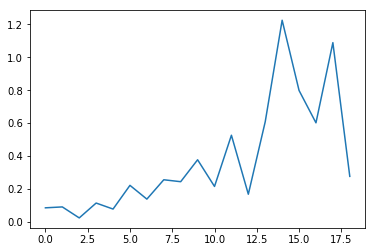

In [14]:
 _ = plt.plot(backfit.output_model_variation['e2'])

In [15]:
for values in backfit.output_model_dict.values():
    print(values.coef_())
    print(values.get_feature_names())

0


AttributeError: 'RandomForestRegression' object has no attribute 'get_feature_names'

In [ ]:
backfit.output_function_dict['e1'](np.array([1,1,1]).reshape(1,-1))

In [ ]:
backfit.output_function_dict['e1']